<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/HUPV/notebooks/cv11_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11. Cvičenie - DeepDream, Vizualizácia, Pomýlenie siete

Na tomto cvičení si najprv ukážeme ako naimplementovať DeepDream pre zosílenie príznakov v obrázku. Následne si naimplemntujeme útok na sieť v ktorom mierne zmeníme hodnoty v pixeloch, tak aby sa sieť na výstupe mýlila. Nakoniec si naimplementujeme jednoduchý spôsob ako zobraziť časti dôležité pre sieť.

Najprv si stiahneme obrázky. Tentokrát si ich rovno prehodíme do RGB.

In [1]:
import cv2

test_imgs = []
!wget https://pixnio.com/free-images/2017/06/08/2017-06-08-13-53-59-900x576.jpg
test_imgs.append(cv2.resize(cv2.imread('2017-06-08-13-53-59-900x576.jpg'),(224,224))[:, :, ::-1].copy())
!wget https://storage.needpix.com/rsynced_images/diver-1881751_1280.jpg
test_imgs.append(cv2.resize(cv2.imread('diver-1881751_1280.jpg'),(224,224))[:, :, ::-1].copy())
!wget https://cdn.pixabay.com/photo/2017/09/22/23/24/white-stork-2777489_960_720.jpg
test_imgs.append(cv2.resize(cv2.imread('white-stork-2777489_960_720.jpg'),(224,224))[:, :, ::-1].copy())
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Croatia_police_van_%2804%29.JPG/800px-Croatia_police_van_%2804%29.JPG
test_imgs.append(cv2.resize(cv2.imread('800px-Croatia_police_van_(04).JPG'),(224,224))[:, :, ::-1].copy())

--2021-12-15 16:12:41--  https://pixnio.com/free-images/2017/06/08/2017-06-08-13-53-59-900x576.jpg
Resolving pixnio.com (pixnio.com)... 170.249.203.179
Connecting to pixnio.com (pixnio.com)|170.249.203.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311968 (305K) [image/jpeg]
Saving to: ‘2017-06-08-13-53-59-900x576.jpg’

2017-06-08-13-53-59 100%[===================>] 304.66K   428KB/s    in 0.7s    

2021-12-15 16:12:42 (428 KB/s) - ‘2017-06-08-13-53-59-900x576.jpg’ saved [311968/311968]

--2021-12-15 16:12:43--  https://storage.needpix.com/rsynced_images/diver-1881751_1280.jpg
Resolving storage.needpix.com (storage.needpix.com)... 89.40.7.139
Connecting to storage.needpix.com (storage.needpix.com)|89.40.7.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282433 (276K) [application/octet-stream]
Saving to: ‘diver-1881751_1280.jpg’

diver-1881751_1280. 100%[===================>] 275.81K   142KB/s    in 1.9s    

2021-12-15 16:12:

Obrázok si môžeme zobraziť

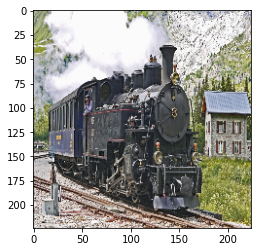

In [2]:
from matplotlib import pyplot as plt

plt.imshow(test_imgs[0])
plt.show()

Na ďalšiu prácu použijeme predtrénovaný ResNet50. Model si prepíšeme tak aby mal na vstupe tezor obrázku v rozsahu 0-255 s kanálmi na konci.


Napíšeme si k tomu aj funkciu ktorá obrázok upraví tak aby mal také hodnoty ako sieť očakáva na vstupe. Aby sme si overili, že model funguje tak si ho otestujeme na obrázku lokomotívy. Dostaneme triedu číslo 820, čo je podľa [zoznamu ImageNetových tried](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) naozaj parná lokomotíva.

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

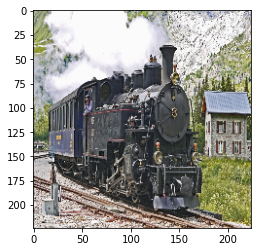

tensor(820, device='cuda:0')


In [3]:
import numpy as np
import torch
from torchvision import models, transforms

class PreprocessModel(torch.nn.Module):
  def __init__(self, model):
    super(PreprocessModel, self).__init__()
    self.model = model
    self.register_buffer('means', torch.Tensor([[[0.485, 0.456, 0.406]]]))
    self.register_buffer('vars', torch.Tensor([[[0.229, 0.224, 0.225]]]))

  def forward(self, x):
    x = x / 255.0
    x -= self.means
    x /= self.vars
    x = torch.permute(x, (2, 0, 1))
    x = torch.unsqueeze(x, 0)
    x = self.model(x)
    return x

model = models.resnet50(pretrained=True)
preprocess_model = PreprocessModel(model).eval().cuda()

pred = preprocess_model(torch.from_numpy(test_imgs[0]).float().cuda())

plt.imshow(test_imgs[0])
plt.show()
print(torch.argmax(pred[0]))

## DeepDream

Teraz si ukážeme kód k zjednodušenej verzii DeepDreamu. Princíp spočíva v tom, že postupne pomocou gradientného vzostupu upravujeme jednotlivé pixely z vstupného obrázka tak aby maximalizovali nejakú vrstvu. Najprv sa pozrieme aké vrstvy sú k dispozícii.

V tomto notebooku si spravíme len základný algoritmus DeepDreamu. Ak by ste chceli generovať krajšie obrázky, tak je nutné robiť ešte ďalšie triky ako napr. spracovanie obrázka na rôznach škálach, náhodné translácie, vyhladzovanie a regularizácia.


In [4]:
print(preprocess_model)

PreprocessModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

Potom môžeme pomocou pomocnej metódy vygenerovať model, ktorý nám vráte nejakú príznakovú mapu zo sieťe. Pre danú sieť si model môžeme aj zobraziť.

(['x', 'truediv', 'sub', 'truediv_1', 'permute', 'unsqueeze', 'model.conv1', 'model.bn1', 'model.relu', 'model.maxpool', 'model.layer1.0.conv1', 'model.layer1.0.bn1', 'model.layer1.0.relu', 'model.layer1.0.conv2', 'model.layer1.0.bn2', 'model.layer1.0.relu_1', 'model.layer1.0.conv3', 'model.layer1.0.bn3', 'model.layer1.0.downsample.0', 'model.layer1.0.downsample.1', 'model.layer1.0.add', 'model.layer1.0.relu_2', 'model.layer1.1.conv1', 'model.layer1.1.bn1', 'model.layer1.1.relu', 'model.layer1.1.conv2', 'model.layer1.1.bn2', 'model.layer1.1.relu_1', 'model.layer1.1.conv3', 'model.layer1.1.bn3', 'model.layer1.1.add', 'model.layer1.1.relu_2', 'model.layer1.2.conv1', 'model.layer1.2.bn1', 'model.layer1.2.relu', 'model.layer1.2.conv2', 'model.layer1.2.bn2', 'model.layer1.2.relu_1', 'model.layer1.2.conv3', 'model.layer1.2.bn3', 'model.layer1.2.add', 'model.layer1.2.relu_2', 'model.layer2.0.conv1', 'model.layer2.0.bn1', 'model.layer2.0.relu', 'model.layer2.0.conv2', 'model.layer2.0.bn2', 'mo

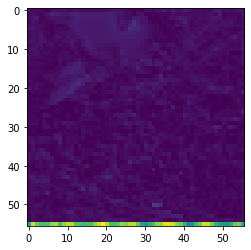

In [5]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

names = get_graph_node_names(preprocess_model)
print(names)

nodes = {'model.layer1.1.conv3': 'out'}

model_feat = create_feature_extractor(preprocess_model, return_nodes=nodes)
feat = model_feat(torch.from_numpy(test_imgs[0]).float().cuda())
print(feat['out'].shape)
plt.imshow(np.abs(feat['out'][0, 0, :, :].detach().cpu().numpy()))
plt.show()
plt.imshow(np.abs(feat['out'][0, 20, :, :].detach().cpu().numpy()))
plt.show()
plt.imshow(np.abs(feat['out'][0, 30, :, :].detach().cpu().numpy()))
plt.show()

Tento extraktor potom môžeme dať dohromady a spraviť gradientný vzostup, tak aby sme maximalizovali aktivácie v danej vrstve.

In [6]:
from tqdm import tqdm

def deep_dream(img, model, layer_name, channel=None, eta=0.1, steps=1000):
  input_tensor = torch.autograd.Variable(torch.from_numpy(img).float(), requires_grad=True).cuda()
  input_tensor.retain_grad()

  nodes = {layer_name: 'out'}
  model_feat = create_feature_extractor(model, return_nodes=nodes)

  for i in tqdm(range(steps)):
    feat = model_feat(input_tensor)
    if channel is not None:
      feat = feat['out'][:, channel, :, :]
    else:
      feat = feat['out']

    loss = torch.mean(feat ** 2)
    loss.backward()

    input_tensor.data += eta * input_tensor.grad.data
    input_tensor.grad.data.zero_()
    model_feat.zero_grad() 

  return input_tensor.detach().cpu().numpy()
    


Kód si otestujeme

100%|██████████| 100/100 [00:06<00:00, 14.47it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


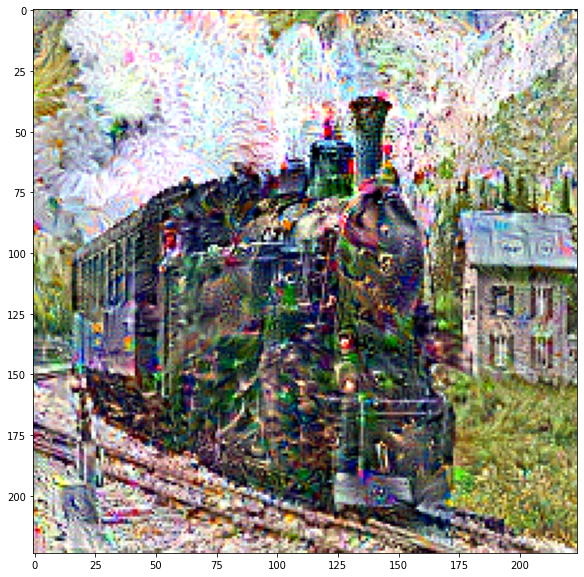

100%|██████████| 100/100 [00:06<00:00, 14.75it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


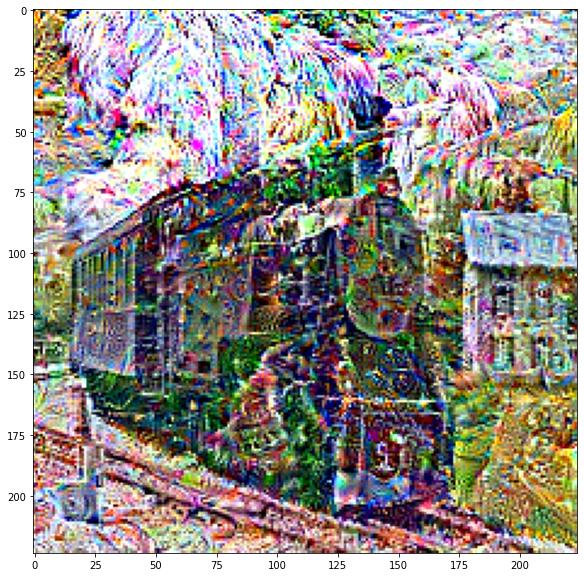

In [7]:
dream_img = deep_dream(test_imgs[0], preprocess_model, 'model.layer4.1.conv3', channel=30, eta=1e7, steps=100)
plt.figure(figsize = (10,10))
plt.imshow(dream_img / 255)
plt.show()

dream_img = deep_dream(test_imgs[0], preprocess_model, 'model.layer4.1.conv3', channel=212, eta=1e7, steps=100)
plt.figure(figsize = (10,10))
plt.imshow(dream_img / 255)
plt.show()

100%|██████████| 200/200 [00:12<00:00, 15.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


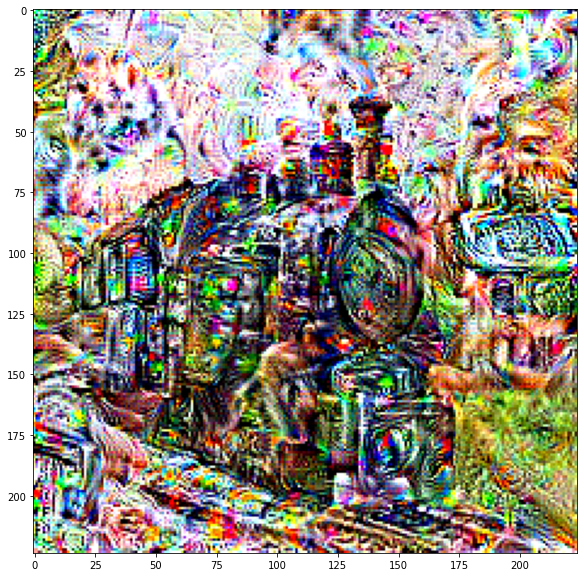

In [8]:
dream_img = deep_dream(test_imgs[0], preprocess_model, 'model.layer4.1.conv1', channel=None, eta=1e6, steps=200)
plt.figure(figsize = (10,10))
plt.imshow(dream_img / 255)
plt.show()

100%|██████████| 200/200 [00:02<00:00, 83.84it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


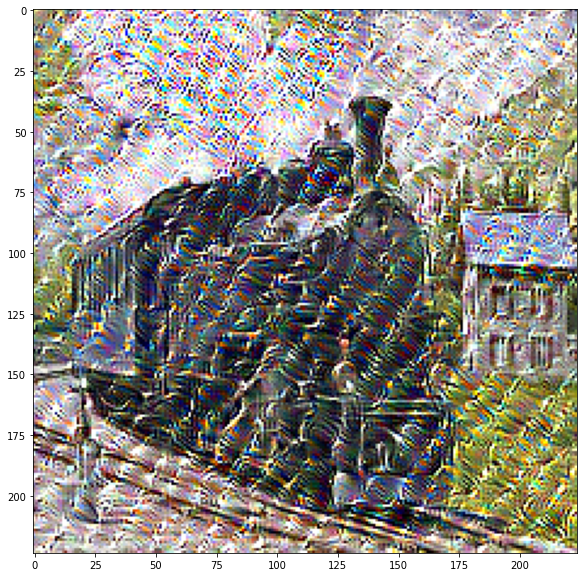

100%|██████████| 200/200 [00:03<00:00, 64.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


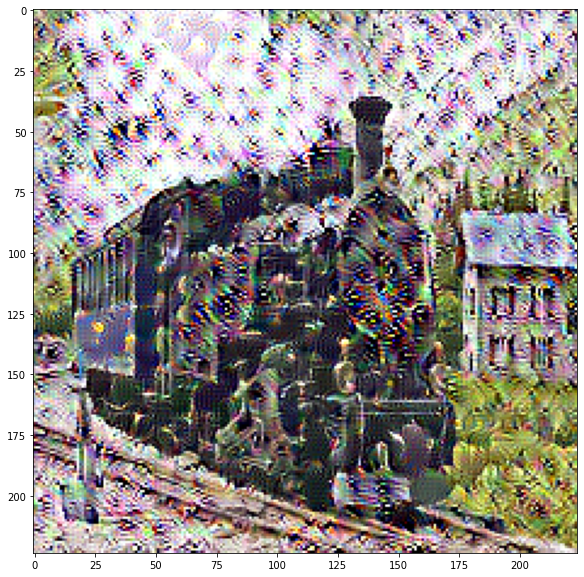

In [9]:
dream_img = deep_dream(test_imgs[0], preprocess_model, 'model.layer1.2.relu_1', channel=30, eta=1e6, steps=200)
plt.figure(figsize = (10,10))
plt.imshow(dream_img / 255)
plt.show()

dream_img = deep_dream(test_imgs[0], preprocess_model, 'model.layer2.0.conv2', channel=21, eta=1e6, steps=200)
plt.figure(figsize = (10,10))
plt.imshow(dream_img / 255)
plt.show()

## Úloha - Pomýlenie siete

Teraz si naimplementujeme jednoduchú metódu na oklamanie siete. Budeme meniť vstupný obrázok tak aby sa sieť pomýlila a klasifikovala vstupný obrázok zle. To urobíme tak, že budeme meniť hodnoty pixelu tak aby pravdepodobnosť našej triedy bola menšia. Skúste teda vymyslieť ako naformulovať loss ktorú budeme optimalizovať.

Pri updatoch nebudeme robiť postupné kroky ako doteraz pomocou:

$$ I_{i, j}^{n + 1} = I_{i, j}^{n} + \eta \frac{\partial L}{\partial I_{i, j}}$$

Pretože pri takomto prístupe meníme hodnoty pixelov aj o neceločíselné hodnoty. Tým pádom ak obrázok uložíme, tak sa možno nami želaný efekt pomýlenia pominie. Preto môžeme každý pixel rovno zmeniť o celú hodnotu podľa znamienka gradientu. Táto metóda sa nazýva FGSMa spočíva v zmene tohto pravidla na:

$$ I_{i, j}^{n + 1} = I_{i, j}^{n} + sgn \left(\frac{\partial L}{\partial I_{i, j}} \right)$$,

kde $sgn$ je funkcia signum. Teda vždy budeme prirátavať k obrázku pixelu buď 0, 1, alebo -1. Takto vieme omnoho rýchlejšie meniť obrázok. Má to navyše výhodu, že ak máme pôvondý obrázok v uint8 a pri preprocessingu sme žiadny kanál neprenásobovali (tak ako v našom prípade keď len odčítame hodnoty), tak po tejto zmene máme stále valídny obrázok.

Pri tejto metóde zastavte úpravy obrázku keď bude sieť dostatočne pomýlená. Tj. pravdepodobnosť správnej triedy bude výrazne nižšia iná trieda.

Úlohu skúste naimplementovať. Môžete použiť štruktúru kódu deep dream.


In [10]:
def adversarial(img, model):
  input_tensor = torch.autograd.Variable(torch.from_numpy(img).float(), requires_grad=True).cuda()
  input_tensor.retain_grad()

  pred = model(input_tensor)

  true_class = torch.argmax(pred[0])

  while pred[0, true_class].item() > 0.001:
    
    pred = model(input_tensor)
    loss = pred[0, true_class]
    loss.backward()

    input_tensor.data -= torch.sign(input_tensor.grad.data)    
    input_tensor.data = torch.clip(input_tensor, 0.0, 255.0)
    input_tensor.grad.data.zero_()
    model_feat.zero_grad() 

  return input_tensor.detach().cpu().numpy()    

Kód si môžete otestovať.

Original prediction:  820
New prediction:  679


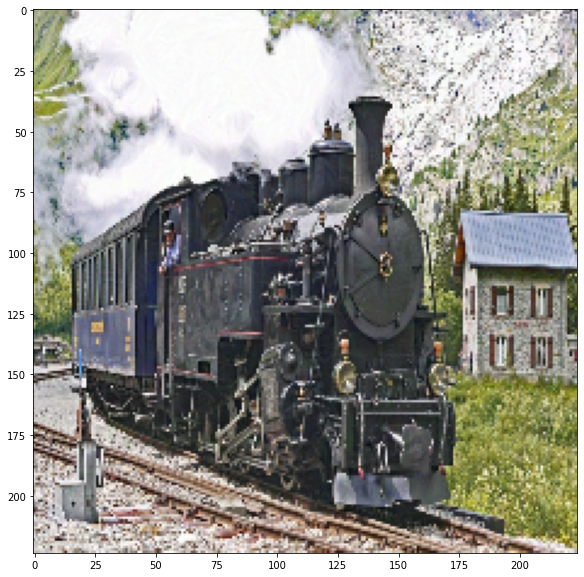

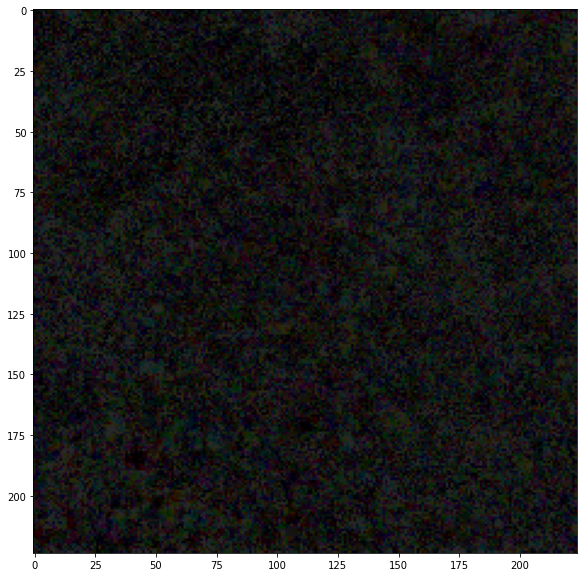

In [11]:
pred = preprocess_model(torch.from_numpy(test_imgs[0]).float().cuda())
print("Original prediction: ", torch.argmax(pred).item())

plt.figure(figsize = (10,10))
adv_img = adversarial(test_imgs[0], preprocess_model)

plt.imshow(adv_img / 255)
pred = preprocess_model(torch.from_numpy(adv_img).float().cuda())
print("New prediction: ", torch.argmax(pred).item())

plt.figure(figsize = (10,10))
plt.imshow(np.abs(adv_img - test_imgs[0]) / 25.5)
plt.show()

## 2. Úloha

V rámci druhej úlohy skúste implementovať podobný prístup, ale s tým že si budeme môcť zadať akú triedu chceme aby náš vygenerovaný obrázok mal.

In [12]:
def adversarial_specific(img, model, desired_class):
  input_tensor = torch.autograd.Variable(torch.from_numpy(img).float(), requires_grad=True).cuda()
  input_tensor.retain_grad()

  pred = model(input_tensor)

  true_class = torch.argmax(pred[0])

  while pred[0, desired_class] < torch.max(pred):
    pred = model(input_tensor)
    loss = pred[0, desired_class] - pred[0, true_class]
    loss.backward()

    input_tensor.data += torch.sign(input_tensor.grad.data)
    input_tensor.data = torch.clip(input_tensor, 0.0, 255.0)
    input_tensor.grad.data.zero_()
    model_feat.zero_grad() 

  return input_tensor.detach().cpu().numpy()    

Kód si môžeme otestovať.

Original prediction:  820


New prediction:  10


New prediction:  45


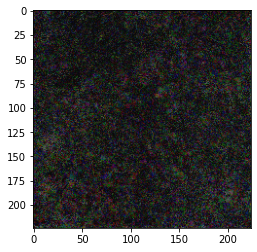

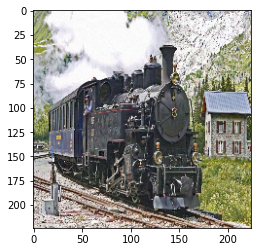

New prediction:  874


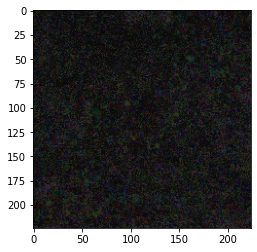

In [13]:
pred = preprocess_model(torch.from_numpy(test_imgs[0]).float().cuda())
print("Original prediction: ", torch.argmax(pred).item())

for desired_class in [10, 45, 874]:
  adv_img = adversarial_specific(test_imgs[0], preprocess_model, desired_class)

  plt.imshow(adv_img / 255)
  plt.show()
  pred = preprocess_model(torch.from_numpy(adv_img).float().cuda())
  print("New prediction: ", torch.argmax(pred).item())

  plt.imshow(np.abs(adv_img - test_imgs[0]) / 25.5)
  plt.show()

## 3. Úloha - Zobrazenie oblastí dôležitých pre sieť

Teraz si skúsime overiť ktoré časti v obraze sú pre klasifikáciu dôležité. To spravíme tak, že si vezmeme testovací obrázok zistíme ako sieť klasifikuje. Potom do obrázka budeme vkladať na rôzne miesta čierny štvorec. Potom zistíme ako veľmi sa zmenila predpoveď modelu. Z týchto zmien potom spravíme heatmapu.

Túto funkciu napíšte tak aby vrátila heatmapu veľkosti $rectangle\_num \times rectangle\_num$. Jednotlivé elementy heatmapy budú reprezentovať to ako veľmi sa zmení predikcia pre pôvodnú triedu obrázku ak na korešpondujúce miesto v obrázku pridáme čierny štvorec veľkosti $rectangle\_size \times rectangle\_size$. Použite napr. cv2.rectangle.

Na začiatku samozrejme musíte zistiť, ktorá trieda je predikovaná pre pôvodný obrázok. Potom sa vždy na výstupe budeme pozerať na hodnotu na danom indexe. Čim viac sa zníži tým väčšiu hodnotu dáme do heatmapy. Tým pádom nám heatmapa ukáža ktoré časti sú pre sieť najdôležitejšie.

In [14]:
def generate_heatmap(img, model, rectangle_num, rectangle_size):
  pred = model(torch.from_numpy(img).float().cuda())
  class_id = torch.argmax(pred[0])
  print(class_id)

  heatmap = np.zeros([rectangle_num, rectangle_num])
  xs = np.linspace(0,224,rectangle_num)
  ys = np.linspace(0,224,rectangle_num)
  for idx_y, y in enumerate(ys):
    for idx_x, x in enumerate(xs):
      c_img = test_img.copy()
      c_img = cv2.rectangle(c_img, (int(x - rectangle_size), int(y - rectangle_size)), (int(x + rectangle_size), int(y + rectangle_size)), (0, 0, 0), -1)
      c_img = torch.from_numpy(c_img).float().cuda()      
      pred = model(c_img)
      heatmap[idx_y, idx_x] = 1 - pred[:, class_id].cpu().detach().numpy()
  return heatmap

Tento kód by mal vygenerovať heatmapy pre testovacie obrázky.

tensor(820, device='cuda:0')


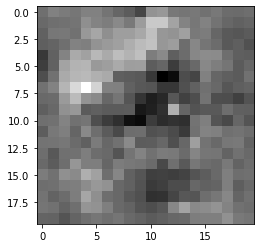

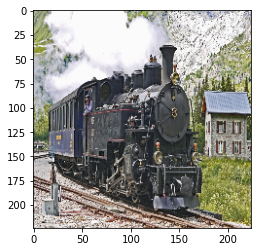

tensor(983, device='cuda:0')


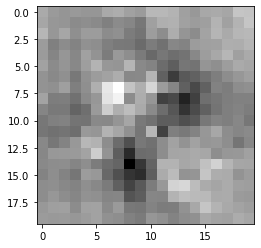

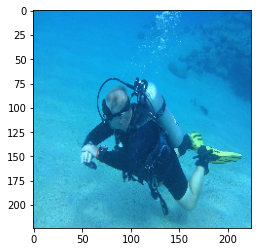

tensor(127, device='cuda:0')


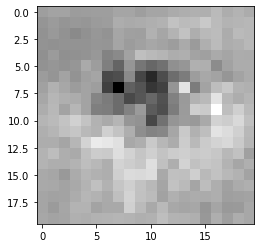

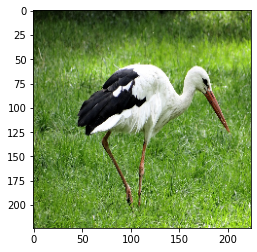

tensor(734, device='cuda:0')


In [15]:
for test_img in test_imgs:
  hmap = generate_heatmap(test_img, preprocess_model, 20, 9)
  plt.imshow(hmap,cmap='gray')
  plt.show()
  plt.imshow(test_img)
  plt.show()